导入库

In [1]:
import datetime as dt
import gc
import logging
import time
from functools import lru_cache

import akshare as ak
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.interpolate as spi
import seaborn as sns
from dateutil import relativedelta as rd
from matplotlib import pyplot as plt
from numba import jit, njit, prange
from scipy.optimize import brentq as bq
from tqdm.auto import tqdm, trange
import mplfinance as mpf

pd.set_option("display.max_columns", None)

plt.rcParams["font.sans-serif"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False

logging.basicConfig(level=logging.INFO)

%config InlineBackend.figure_format = 'retina'

# PDE边界条件

OTU：![OTU](https://mmbiz.qpic.cn/sz_mmbiz_png/W8WPnMziarbHabTDT2QgddsJ8micyPg1zMtht9FbMfLMtHvUkAU6WHaK5p3vQ3HxA2Wibjg78vffibBgoPkFIUF2mw/?wx_fmt=png)

DNT：![DNT](https://mmbiz.qpic.cn/sz_mmbiz_png/W8WPnMziarbHabTDT2QgddsJ8micyPg1zMd2LQa95y4ibLIRQzh4r8gicAazhGdWF8CdJvHp564IaWqJ8Xia36Lz8Dw/?wx_fmt=png&tp=png&wxfrom=5&wx_lazy=1&wx_co=1)

DKOP：![DKOP](https://mmbiz.qpic.cn/sz_mmbiz_png/W8WPnMziarbHabTDT2QgddsJ8micyPg1zMpdx4sUaOav05tyUFz5Bqia9VET5DD7RQVBlq7ugq0tRiccREtCr6uIFA/?wx_fmt=png)

UOP：![UOP](https://mmbiz.qpic.cn/sz_mmbiz_png/W8WPnMziarbHabTDT2QgddsJ8micyPg1zMJ00PaRguyxVCdky3u6SZ5WrB3ctCicqBYUQ8N6SV3JMbGJAyRFa3tMQ/?wx_fmt=png&tp=png&wxfrom=5&wx_lazy=1&wx_co=1)

# 自定义雪球类

In [2]:
class SnowballPDE:
    def __init__(
        self,
        r,
        q,
        vol,
        s0,
        start_date,
        end_date,
        calendar,
        lock_term,
        coupon_out,
        coupon_div,
        barrier_out,
        barrier_in,
        s_steps=4000,
        n_smax=4,
    ):
        # BS公式参数
        self.r = r  # 无风险利率
        self.q = q  # 股息率
        self.vol = vol  # 波动率
        self.s0 = s0  # 期初标的价格
        # 雪球独有参数
        self.start_date = start_date  # 观察起始日期
        self.end_date = end_date  # 结束日期
        self.calendar = calendar  # 交易日历
        self.lock_term = lock_term  # 锁定期
        self.coupon_out = coupon_out  # 敲出票息
        self.coupon_div = coupon_div  # 红利票息
        self.barrier_out = barrier_out  # 敲出障碍价格
        self.barrier_in = barrier_in  # 敲入障碍价格
        # PDE参数
        self.s_steps = s_steps  # 价格步数
        self.s_max = n_smax * max(self.s0, self.barrier_out)  # 价格最大值
        self.s_min = 0.0  # 价格最小值
        # 初始化参数
        self.initialize_params()

    def initialize_params(self):
        # 所有交易日期
        self.trade_dates = self.calendar[
            (self.calendar >= self.start_date) & (self.calendar <= self.end_date)
        ]
        # 敲入观察日
        self.ki_obs_dates = self.trade_dates[
            (
                self.trade_dates
                >= self.start_date + rd.relativedelta(months=self.lock_term)
            )
        ]
        # 敲出观察日
        self.ko_obs_dates = self.trade_dates[
            (
                self.trade_dates
                >= self.start_date + rd.relativedelta(months=self.lock_term)
            )
            & (self.trade_dates.month != self.trade_dates.shift(-1, freq="B").month)
        ]
        # 期权存续时间(年)
        self.maturity = self.trade_dates[-1].year - self.trade_dates[0].year
        # 时间步数
        self.t_steps = len(self.trade_dates) - 1

    def initialize_grid(self):
        """初始化网格"""
        # 价格序列
        self.s_vec = np.linspace(self.s_min, self.s_max, num=self.s_steps + 1)
        # 时间序列
        self.t_vec = np.linspace(0, self.maturity, num=self.t_steps + 1)
        # 价格索引
        self.i_vec = np.linspace(0, self.s_steps, self.s_steps + 1)
        # 时间索引
        self.j_vec = np.linspace(0, self.t_steps, self.t_steps + 1)

        # 初始化期权价值网格
        self.otu_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))
        self.dnt_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))
        self.dkop_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))
        self.uop_grid = np.zeros((self.s_steps + 1, self.t_steps + 1))

    def set_boundary_conditions(self):
        """设置边界条件"""
        # 设置敲入线、敲出线的情况
        self.s_mask_out = self.s_vec >= self.barrier_out
        self.s_mask_in = self.s_vec <= self.barrier_in
        self.t_mask_out = self.trade_dates.isin(self.ko_obs_dates)
        self.t_mask_in = self.trade_dates.isin(self.ki_obs_dates)

        # 计算每个交易日到下一个敲出观察日的距离
        next_ko_index = np.searchsorted(self.trade_dates, self.ko_obs_dates)
        # 增加到期日索引
        next_ko_index = np.append(next_ko_index, len(self.trade_dates) - 1)
        # 利用广播机制拓展为t_vec的长度
        next_ko_index = next_ko_index[np.searchsorted(next_ko_index, self.j_vec)]

        # OTU：上涨触碰生效期权
        # 下边界
        # S=S_min时，期权价值为0
        self.otu_grid[0, :] = 0.0
        # 上边界
        # S=S_max时，敲出观察日为C*t_ko的票息，其余各点由下一敲出观察日的票息贴现
        # 计算上边界的价值
        self.otu_grid[-1, :] = (
            self.coupon_out * self.s0 * self.t_vec[next_ko_index]
        ) * np.exp(-self.r * (self.t_vec[next_ko_index] - self.t_vec))
        # 右边界
        # S>ko时，支付C*T的票息，否则价值为0
        self.otu_grid[self.s_mask_out, -1] = self.coupon_div * self.s0 * self.maturity
        self.otu_grid[~self.s_mask_out, -1] = 0.0

        # DNT：双边触碰失效期权
        # 下边界
        # S=S_min时，期权价值为0
        self.dnt_grid[0, :] = 0.0
        # 上边界
        # S=S_max时，期权价值为0
        self.dnt_grid[-1, :] = 0.0
        # 右边界
        # S>ko时，支付C*T的票息，否则价值为0
        self.dnt_grid[self.s_mask_out | self.s_mask_in, -1] = 0.0
        self.dnt_grid[~self.s_mask_out & ~self.s_mask_in, -1] = (
            self.coupon_div * self.s0 * self.maturity
        )

        # DKOP：双边触碰失效看跌期权
        # 下边界
        # S=S_min时，期权价值为0
        self.dkop_grid[0, :] = 0.0
        # 上边界
        # S=S_max时，期权价值为0
        self.dkop_grid[-1, :] = 0.0
        # 右边界
        # ki<S<ko时，payoff为max(ki-S,0)，否则价值为0
        self.dkop_grid[~self.s_mask_in & ~self.s_mask_out, -1] = np.maximum(
            self.s0 - self.s_vec[~self.s_mask_in & ~self.s_mask_out], 0
        )
        self.dkop_grid[self.s_mask_in | self.s_mask_out, -1] = 0.0

        # UOP：向上敲出失效看涨期权
        # 下边界
        # S=S_min时，期权价值为T时刻期权价值S0的折现
        self.uop_grid[0, :] = (
            self.s0 * np.exp(-self.r * (self.maturity - self.t_vec)) - self.s_min
        )
        # 上边界
        # S=S_max时，期权价值为0
        self.uop_grid[-1, :] = 0.0
        # 右边界
        # S<ko时，payoff为max(S-ko,0)，否则价值为0
        self.uop_grid[~self.s_mask_out, -1] = np.maximum(
            self.s0 - self.s_vec[~self.s_mask_out], 0
        )
        self.uop_grid[self.s_mask_out, -1] = 0.0

    @staticmethod
    @njit(
        cache=True, fastmath=True
    )  # 不要使用parallel=True，因为计算有顺序，不能并行。否则计算结果不对
    def TDMA(a, b, c, d):
        """使用numba.jit加速的三对角矩阵求解Thomas算法
        Args:
            a: np.adarray，三对角系数矩阵的下对角线元素向量
            b: np.adarray，三对角系数矩阵的主对角线元素向量
            c: np.adarray，三对角系数矩阵的上对角线元素向量
            d: np.adarray，方程右端向量
        Returns:
            p: np.adarray，方程的解向量，Xp=d
        """
        n = len(d)
        for i in prange(1, n):
            m = a[i - 1] / b[i - 1]
            b[i] = b[i] - m * c[i - 1]
            d[i] = d[i] - m * d[i - 1]
        p = b
        p[-1] = d[-1] / b[-1]
        indices = np.arange(n - 2, -1, -1)  # 创建逆序索引数组
        for j in prange(n - 1):
            i = indices[j]  # 使用逆序索引
            p[i] = (d[i] - c[i] * p[i + 1]) / b[i]
        return p

    def set_matrix(self):
        """生成系数矩阵"""
        self.dt = self.maturity / self.t_steps
        diffusion_square = (self.vol * self.i_vec[1:-1]) ** 2
        drift = (self.r - self.q) * self.i_vec[1:-1]
        self.lower = 0.25 * self.dt * (diffusion_square - drift)
        self.diag = -0.5 * self.dt * (diffusion_square + self.r)
        self.upper = 0.25 * self.dt * (diffusion_square + drift)
        A = (
            np.diag(self.diag)
            + np.diag(self.lower[1:], -1)
            + np.diag(self.upper[:-1], 1)
        )
        self.M1 = np.eye(self.s_steps - 1) - A
        self.M2 = np.eye(self.s_steps - 1) + A

    def solve_PDE(self):
        """求解PDE"""
        grids = [self.otu_grid, self.dnt_grid, self.dkop_grid, self.uop_grid]

        # Crank-Nicolson差分格式求解PDE，使用Thomas算法求解线性方程组
        # 设置矩阵方程等号右侧的V
        for j in trange(self.t_steps, 0, -1, desc="PDE求解中"):
            for index, grid in enumerate(grids):
                f_j = self.M2.dot(grid[1:-1, j])
                f_j[0] += self.lower[0] * (grid[0, j] + grid[0, j - 1])
                f_j[-1] += self.upper[-1] * (grid[-1, j] + grid[-1, j - 1])
                f_j_1 = self.TDMA(
                    self.M1.diagonal(-1).copy(),
                    self.M1.diagonal(0).copy(),
                    self.M1.diagonal(1).copy(),
                    f_j,
                )

                # 根据子网格类型更新期权价值
                if index == 0:
                    # 迭代过程中如果遇到j-1期为敲出观察日，不能覆盖敲出边界以上的期权价值
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = (
                            self.coupon_out * self.s0 * self.t_vec[j - 1]
                        )
                    grid[1:-1, j - 1] = f_j_1
                elif index == 1:
                    # 迭代过程中如果遇到j-1期为敲入/敲出观察日，不能覆盖敲入边界以下/敲出边界以上的期权价值
                    if self.t_mask_in[j - 1]:
                        f_j_1[self.s_mask_in[1:-1]] = 0.0
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = 0.0
                    grid[1:-1, j - 1] = f_j_1
                elif index == 2:
                    # 迭代过程中如果遇到j-1期为敲入/敲出观察日，不能覆盖敲入边界以下/敲出边界以上的期权价值
                    if self.t_mask_in[j - 1]:
                        f_j_1[self.s_mask_in[1:-1]] = 0.0
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = 0.0
                    grid[1:-1, j - 1] = f_j_1
                elif index == 3:
                    # 迭代过程中如果遇到j-1期为敲出观察日，不能覆盖敲出边界以上的期权价值
                    if self.t_mask_out[j - 1]:
                        f_j_1[self.s_mask_out[1:-1]] = 0.0
                    grid[1:-1, j - 1] = f_j_1

        self.v_grid = self.otu_grid + self.dnt_grid + self.dkop_grid - self.uop_grid

    def interpolate(self, s, t=0):
        """插值计算期初时刻的期权价值

        Returns:
            np.array: 期初时的期权价值
        """
        tck = spi.splrep(self.s_vec, self.v_grid[:, t], k=3)
        return spi.splev(s, tck)

    def pricing(self):
        """PDE定价实现

        Returns:
            np.array: 期初时的期权价值
        """
        start = time.time()
        # 初始化网格
        self.initialize_grid()
        # 设置边界条件
        self.set_boundary_conditions()
        # 生成系数矩阵
        self.set_matrix()
        # 求解PDE
        self.solve_PDE()
        end = time.time()
        logging.info(f"price执行完成，耗时{end-start}秒")
        # 返回期初时的期权价值
        return self.interpolate(self.s0)

    def delta(self, s, t=0):
        """计算Delta值"""
        s_step = 0.01 * s
        delta = (self.interpolate(s + s_step, t) - self.interpolate(s - s_step, t)) / (
            2 * s_step
        )
        return delta

    def gamma(self, s, t=0):
        """计算Gamma值"""
        s_step = 0.01 * s
        gamma = (
            self.interpolate(s + s_step, t)
            - 2 * self.interpolate(s, t)
            + self.interpolate(s - s_step, t)
        ) / (s_step**2)
        return gamma

    def pv_and_greeks(self):
        pv = self.pricing()
        delta = self.delta(self.s0)
        gamma = self.gamma(self.s0)
        return {"pv": pv.item(), "delta": delta, "gamma": gamma}

    def pv_grid(self):
        self.pricing()
        return pd.DataFrame(
            self.v_grid,
            index=self.s_vec,
            columns=self.trade_dates,
        )

# 净值化雪球策略

获取收盘数据

In [3]:
stock_list = [
    "002993",
    "002142",
    "00902",
    "01071",
    "03800",
    "01193",
    "300751",
    "600166",
    "603197",
    "300979",
    "600129",
    "600276",
]

# 分配空DataFrame
price_df_A = pd.DataFrame()
price_df_H = pd.DataFrame()
for stock in tqdm(stock_list):
    # 判断为A股代码还是H股代码
    if len(stock) == 6:
        df = ak.stock_zh_a_hist(
            symbol=stock,
            period="daily",
            start_date="20210101",
            end_date=dt.datetime.now().strftime("%Y%m%d"),
            adjust="",
        )[["日期", "收盘"]]
        df.set_index("日期", inplace=True)
        df.index = pd.to_datetime(df.index)
        df.rename(columns={"收盘": stock}, inplace=True)
        price_df_A = pd.concat([price_df_A, df], axis=1)
        del df
    else:
        df = ak.stock_hk_hist(
            symbol=stock,
            period="daily",
            start_date="20210101",
            end_date=dt.datetime.now().strftime("%Y%m%d"),
            adjust="",
        )[["日期", "收盘"]]
        df.set_index("日期", inplace=True)
        df.index = pd.to_datetime(df.index)
        df.rename(columns={"收盘": stock}, inplace=True)
        price_df_H = pd.concat([price_df_H, df], axis=1)
price_df_A.sort_index(inplace=True)
price_df_H.sort_index(inplace=True)

  0%|          | 0/12 [00:00<?, ?it/s]

计算个股波动率

In [4]:
vol_A = price_df_A.loc[
    dt.datetime(2021, 1, 4) : dt.datetime(2022, 1, 4), :
].pct_change().std() * np.sqrt(252)
vol_A

C:\Users\southwall\AppData\Local\Temp\ipykernel_21968\422542587.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ].pct_change().std() * np.sqrt(252)


002993    0.552879
002142    0.384593
300751    0.860600
600166    0.523948
603197    0.487254
300979    0.551530
600129    0.483645
600276    0.385346
dtype: float64

In [5]:
vol_H = price_df_H.loc[
    dt.datetime(2021, 1, 4) : dt.datetime(2022, 1, 4), :
].pct_change().std() * np.sqrt(252)
vol_H

C:\Users\southwall\AppData\Local\Temp\ipykernel_21968\1801420767.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ].pct_change().std() * np.sqrt(252)


00902    0.526335
01071    0.510516
03800    1.227168
01193    0.318844
dtype: float64

参数设定

In [6]:
vol_dict = round(pd.concat([vol_A, vol_H], axis=0), 1).to_dict()
s0_dict = {
    **price_df_A.loc[dt.datetime(2022, 1, 4), :].to_dict(),
    **price_df_H.loc[dt.datetime(2022, 1, 4), :].to_dict(),
}
ki_dict = {k: v * 0.8 for k, v in s0_dict.items()}
ko_dict = {k: v * 1.1 for k, v in s0_dict.items()}

calendar_A = price_df_A.index
calendar_A = calendar_A.append(
    pd.date_range(calendar_A[-1], calendar_A[-1] + rd.relativedelta(years=5), freq="B")
)
calendar_H = price_df_H.index
calendar_H = calendar_H.append(
    pd.date_range(calendar_H[-1], calendar_H[-1] + rd.relativedelta(years=5), freq="B")
)

start_date = dt.datetime(2024, 4, 18)
end_date = dt.datetime(2026, 4, 18)
bt_start_date = dt.datetime(2024, 4, 18)
bt_end_date = dt.datetime.now()
# bt_end_date = dt.datetime(2023, 1, 4)
buy_fee = 0.0005
sell_fee = 0.0015

净值化雪球回测

In [7]:
snowball_returns = pd.DataFrame()
snowball_positions = pd.DataFrame()
stock_returns = pd.DataFrame()
gs_bench_returns = pd.DataFrame()

for stock in stock_list:
    # 初始价格
    s0 = s0_dict[stock]
    # 波动率水平
    vol = vol_dict[stock]
    # 敲入价格
    ki = ki_dict[stock]
    # 敲出价格
    ko = ko_dict[stock]
    # 回测期价格序列
    price_df = price_df_A.loc[:, stock] if len(stock) == 6 else price_df_H.loc[:, stock]
    # 交易日历
    calendar = calendar_A if len(stock) == 6 else calendar_H
    # 初始化

    cash = 1e6
    # 初始化期权类
    option = SnowballPDE(
        r=0.015,
        q=0.00,
        vol=vol,
        s0=s0,
        start_date=start_date,
        end_date=end_date,
        calendar=calendar,
        lock_term=3,
        coupon_out=0.15,
        coupon_div=0.15,
        barrier_out=ko,
        barrier_in=ki,
        s_steps=4000,
    )
    pv = option.pricing()
    logging.info(f"{stock}的期权价格为{pv}")
    # 根据delta对冲获取仓位
    bt_prices = price_df.loc[bt_start_date:bt_end_date]
    daily_delta = []
    for i in range(len(bt_prices)):
        daily_delta.append(option.delta(bt_prices.iloc[i], i))
    # 根据delta推算仓位市值
    delta_cash = pd.Series(
        cash * np.clip(np.array(daily_delta), 0, np.inf), index=bt_prices.index
    )
    # 计算delta_cash对应的仓位
    amount = delta_cash / bt_prices
    # 计算每日需要调整的仓位
    amount_daily = amount.diff(1)
    amount_daily.iloc[0] = amount.iloc[0]
    # 计算每日交易现金流
    trade = round(amount_daily) * bt_prices
    # 计算交易费用
    fee_ratio = np.where(trade >= 0, buy_fee, sell_fee)

    # 考虑到单纯依据delta计算仓位可能会穿仓，每日重新计算仓位
    cash_left = np.empty(len(bt_prices))
    # 初始化第1个交易日的数据
    amount_daily.iloc[0] = round(
        min(
            cash / (bt_prices.iloc[0] * (1 + fee_ratio[0])),
            delta_cash.iloc[0] / bt_prices.iloc[0],
        )
    )
    trade.iloc[0] = amount_daily.iloc[0] * bt_prices.iloc[0]
    cash_left[0] = cash - trade.iloc[0] * (1 + fee_ratio[0])
    amount.iloc[0] = amount_daily.iloc[0]

    for i in range(1, len(bt_prices)):
        # 限制每日仓位调整幅度
        amount_daily.iloc[i] = round(
            min(
                cash_left[i - 1] / (bt_prices.iloc[i] * (1 + fee_ratio[i])),
                delta_cash.iloc[i] / bt_prices.iloc[i] - amount.iloc[i - 1],
            )
        )
        trade.iloc[i] = amount_daily.iloc[i] * bt_prices.iloc[i]
        cash_left[i] = cash_left[i - 1] - trade.iloc[i] * (1 + fee_ratio[i])
        # 更新当日delta_cash仓位
        amount.iloc[i] = amount.iloc[i - 1] + amount_daily.iloc[i]

    # 计算持仓市值
    position = amount_daily.cumsum() * bt_prices
    position.rename(stock, inplace=True)
    # 计算净值变化
    net_value = cash_left + position - trade * fee_ratio
    net_value.rename(stock, inplace=True)

    # 计算净值化雪球收益
    snowball_returns = pd.concat([snowball_returns, net_value], axis=1)
    snowball_positions = pd.concat([snowball_positions, position], axis=1)

    # 计算股票基准收益
    stock_return = round(cash / bt_prices.iloc[0]) * bt_prices
    stock_returns = pd.concat([stock_returns, stock_return], axis=1)

    # 计算Gamma Scalping的基准收益
    gs_bench_return = cash_left[0] + amount.iloc[0] * bt_prices
    gs_bench_returns = pd.concat([gs_bench_returns, gs_bench_return], axis=1)

    # 回收内存
    del (
        s0,
        vol,
        ki,
        ko,
        price_df,
        calendar,
        cash,
        option,
        pv,
        bt_prices,
        daily_delta,
        delta_cash,
        cash_left,
        amount,
        amount_daily,
        trade,
        fee_ratio,
        position,
        net_value,
        stock_return,
        gs_bench_return,
    )
    gc.collect()

snowball_returns.sort_index(inplace=True)
snowball_returns.ffill(inplace=True)
snowball_positions.sort_index(inplace=True)
snowball_positions.ffill(inplace=True)
stock_returns.sort_index(inplace=True)
stock_returns.ffill(inplace=True)
gs_bench_returns.sort_index(inplace=True)
gs_bench_returns.ffill(inplace=True)

PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时15.557812213897705秒
INFO:root:002993的期权价格为-5.165087881976553


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时15.567458868026733秒
INFO:root:002142的期权价格为-2.77978949973001


PDE求解中:   0%|          | 0/519 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时13.09880542755127秒
INFO:root:00902的期权价格为-0.5205766017032804


PDE求解中:   0%|          | 0/519 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时12.425471305847168秒
INFO:root:01071的期权价格为-0.3391945967791157


PDE求解中:   0%|          | 0/519 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时12.544712543487549秒
INFO:root:03800的期权价格为-0.8249415852010055


PDE求解中:   0%|          | 0/519 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时11.875037431716919秒
INFO:root:01193的期权价格为-1.8742768985400773


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时12.59525752067566秒
INFO:root:300751的期权价格为-123.91173502811584


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时12.331084966659546秒
INFO:root:600166的期权价格为-0.3592280260900941


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时13.370590209960938秒
INFO:root:603197的期权价格为-5.731273350725248


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时13.184770822525024秒
INFO:root:300979的期权价格为-11.322861419859972


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时13.15918779373169秒
INFO:root:600129的期权价格为-2.52892436600768


PDE求解中:   0%|          | 0/518 [00:00<?, ?it/s]

INFO:root:price执行完成，耗时13.45387077331543秒
INFO:root:600276的期权价格为-3.7154799175437216


回测结果整理

In [8]:
portfolio_value = snowball_returns.sum(axis=1)
portfolio_return = portfolio_value / (12 * 1e6) - 1
bench_return = stock_returns.sum(axis=1) / (12 * 1e6) - 1
gs_bench_return = gs_bench_returns.sum(axis=1) / (12 * 1e6) - 1
exceed_return = portfolio_return - bench_return
gs_exceed_return = portfolio_return - gs_bench_return
portfolio_position = snowball_positions.sum(axis=1) / (12 * 1e6)

result = pd.concat(
    [
        round(portfolio_value, 0),
        round(portfolio_return * 100, 2),
        round(bench_return * 100, 2),
        round(exceed_return * 100, 2),
        round(gs_bench_return * 100, 2),
        round(gs_exceed_return * 100, 2),
        round(portfolio_position * 100, 2),
    ],
    axis=1,
)
result.columns = [
    "组合市值",
    "组合收益率",
    "股票基准收益率",
    "组合超额收益率",
    "Gamma Scalping基准收益率",
    "Gamma Scalping收益率",
    "组合仓位",
]
result.index = pd.to_datetime(result.index)
result.index.name = "日期"
result

,组合市值,组合收益率,股票基准收益率,组合超额收益率,Gamma Scalping基准收益率,Gamma Scalping收益率,组合仓位
日期,,,,,,,
2024-04-18,11991934.0,-0.07,-0.00,-0.07,-0.03,-0.03,67.22
2024-04-19,11924765.0,-0.63,-0.89,0.27,-0.63,-0.00,67.92
2024-04-22,11858048.0,-1.18,-1.44,0.26,-1.16,-0.02,68.17
2024-04-23,11790052.0,-1.75,-2.42,0.67,-1.73,-0.02,68.63
2024-04-24,11839657.0,-1.34,-1.95,0.62,-1.37,0.03,68.46
2024-04-25,11906220.0,-0.78,-0.90,0.11,-0.82,0.04,68.01
2024-04-26,12030147.0,0.25,0.47,-0.22,0.17,0.08,67.35
2024-04-29,12178037.0,1.48,1.73,-0.25,1.41,0.07,67.40
2024-04-30,12206269.0,1.72,2.61,-0.89,1.64,0.08,66.48


<Axes: xlabel='日期'>

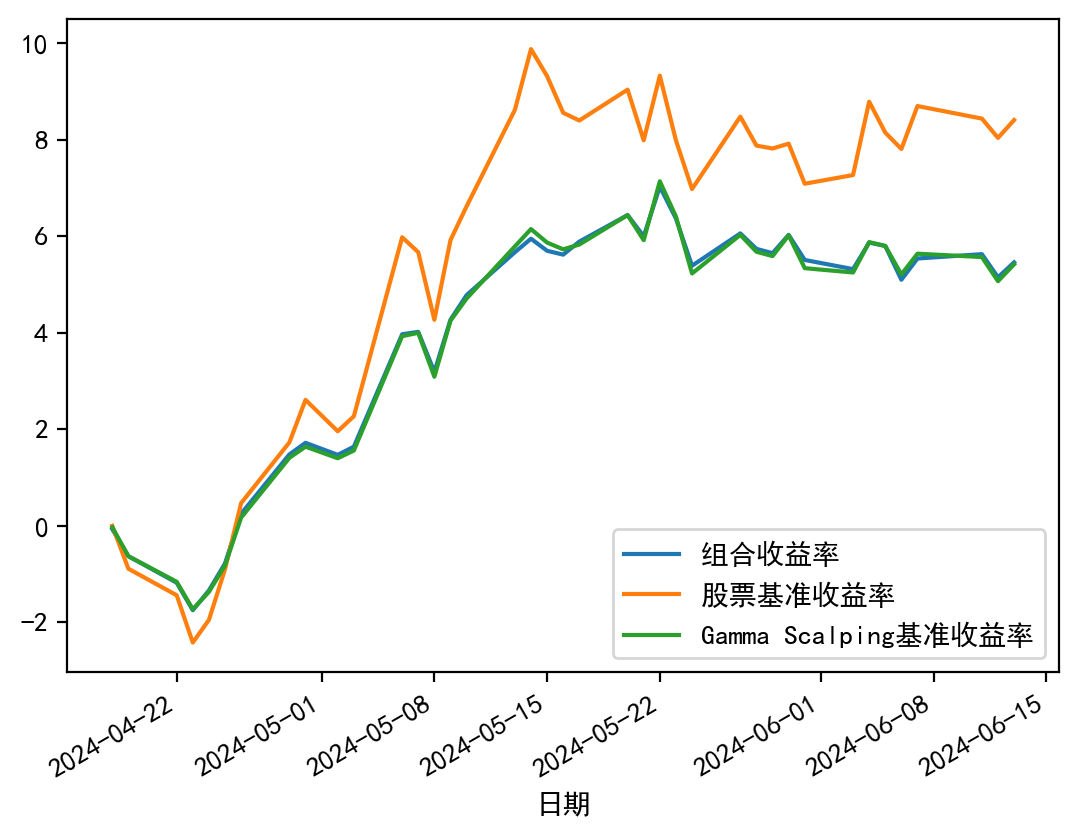

In [9]:
result[["组合收益率", "股票基准收益率", "Gamma Scalping基准收益率"]].plot()

买卖点可视化

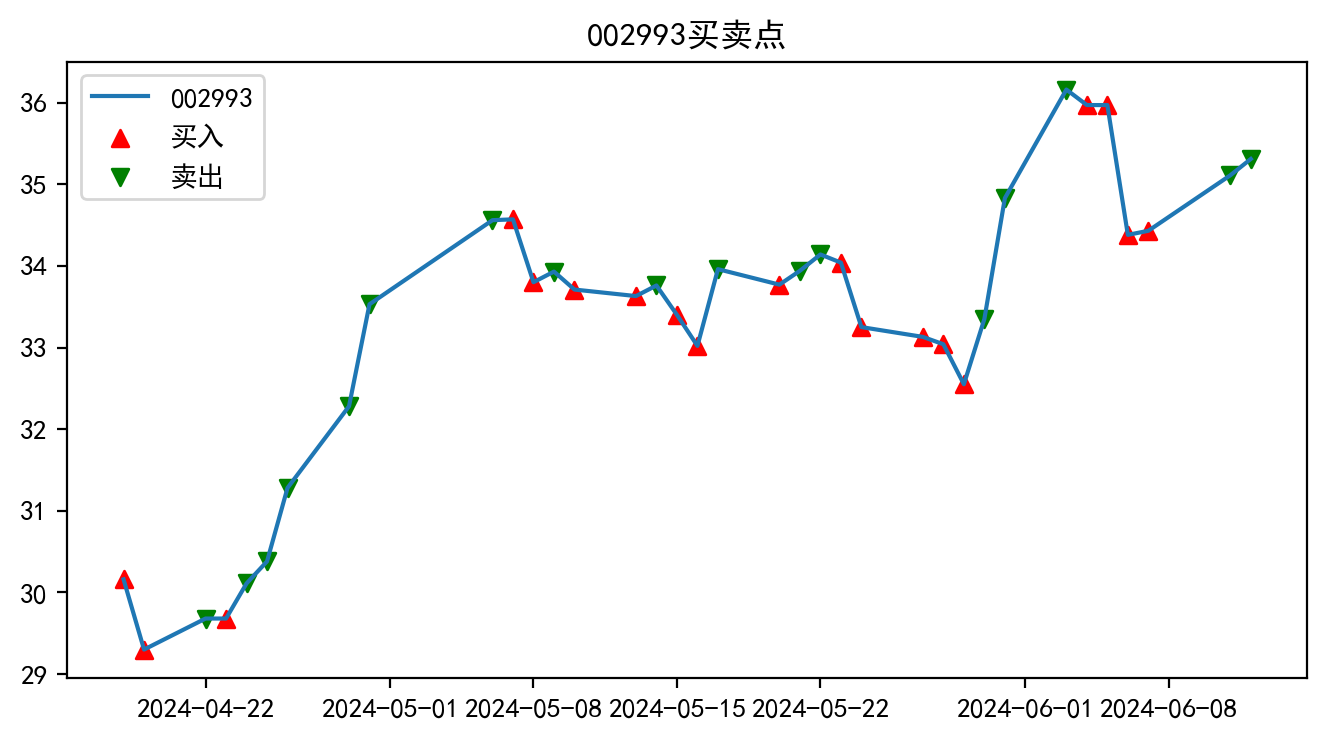

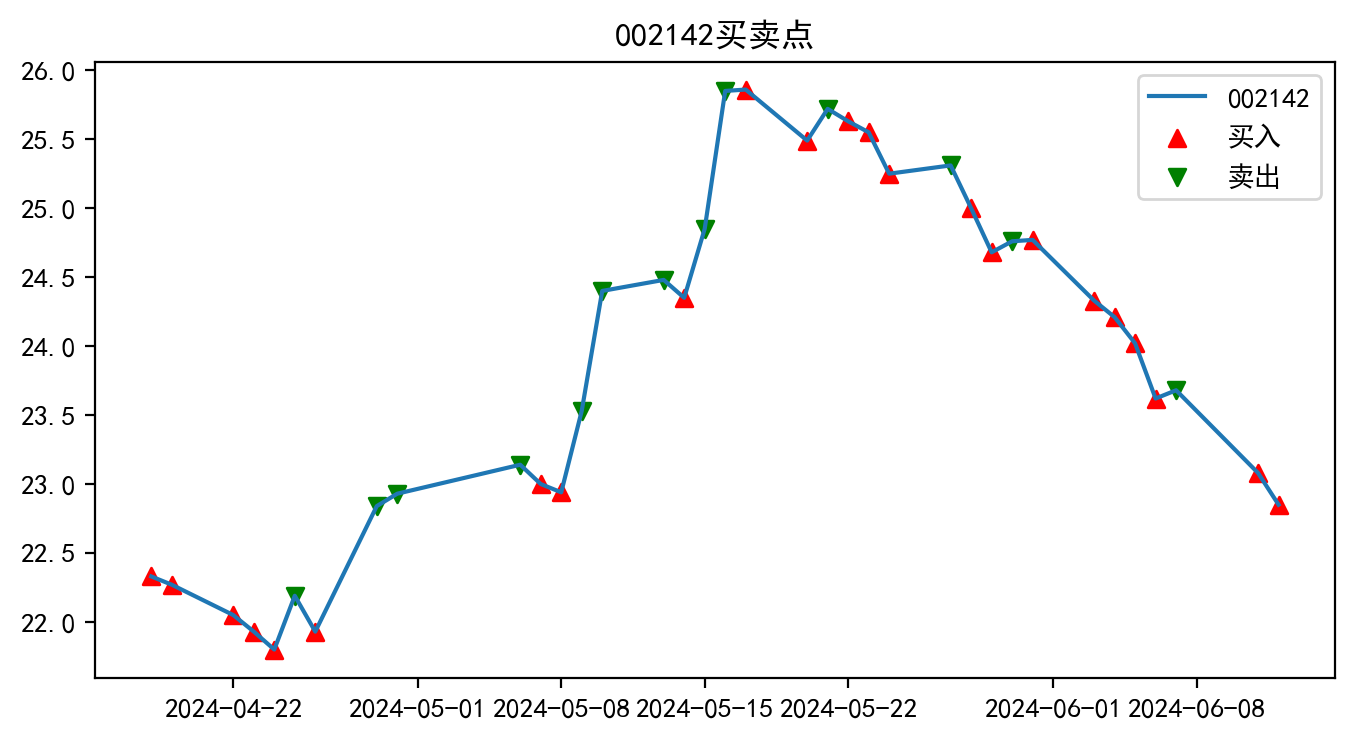

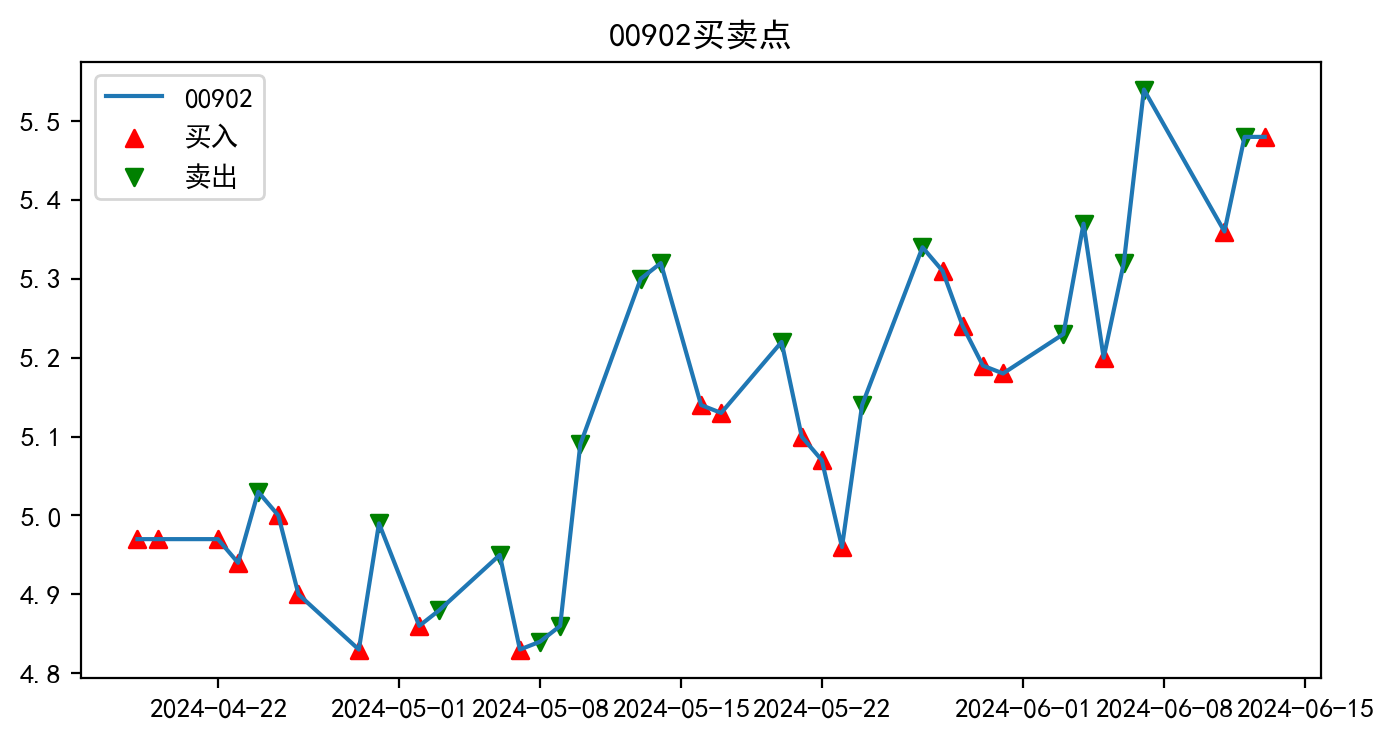

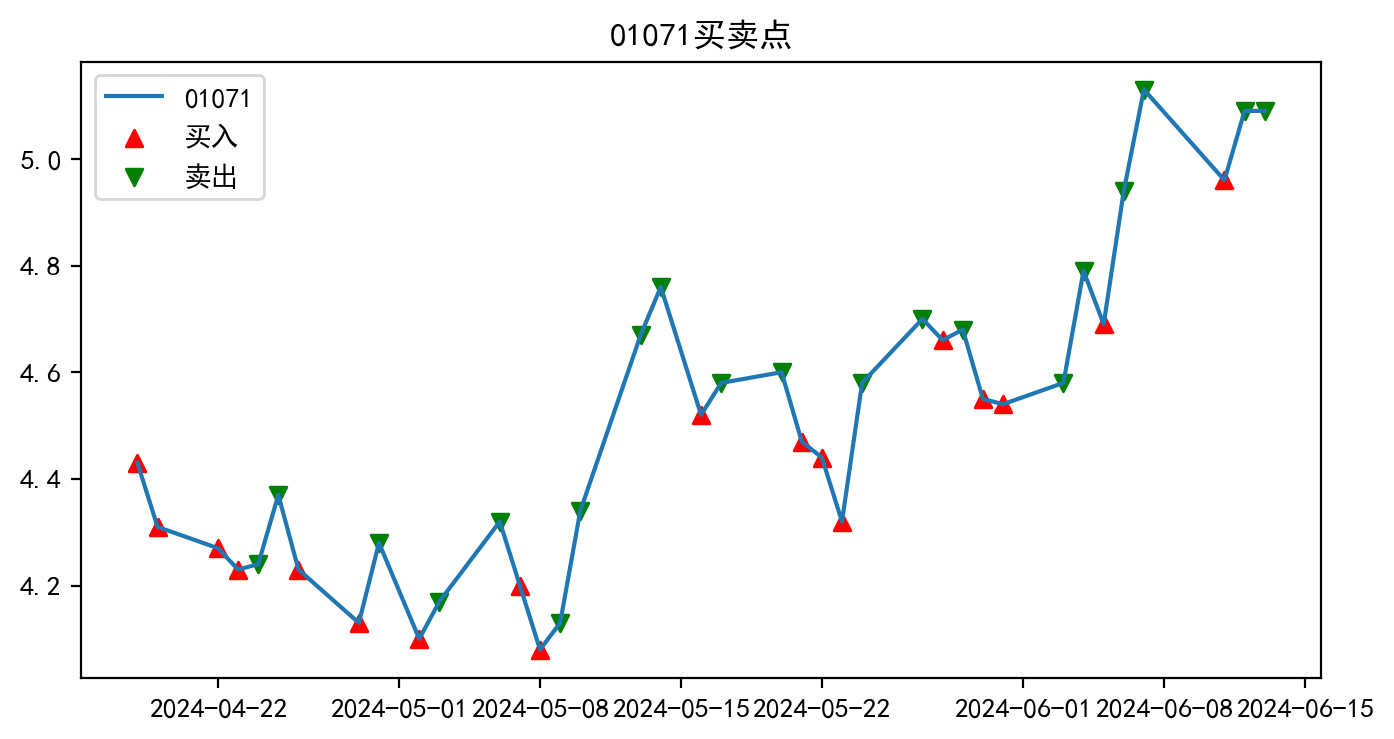

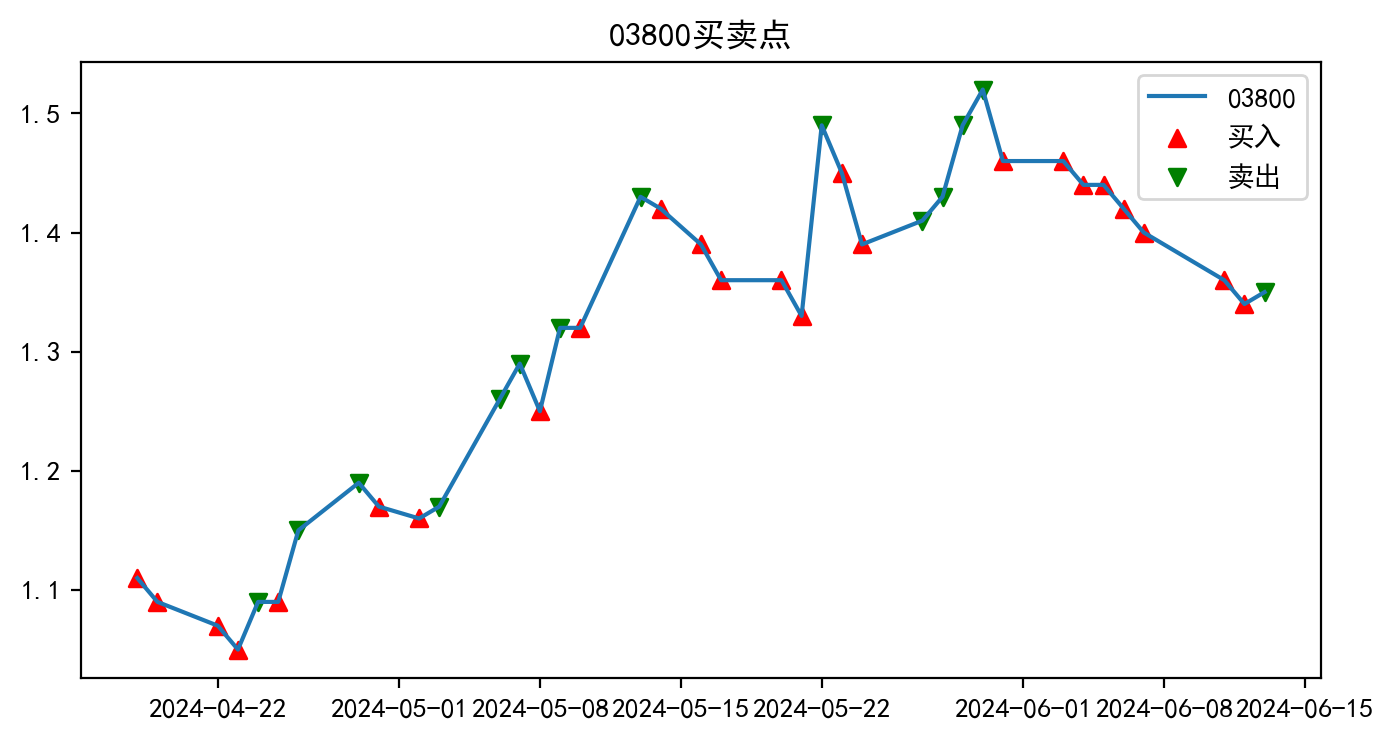

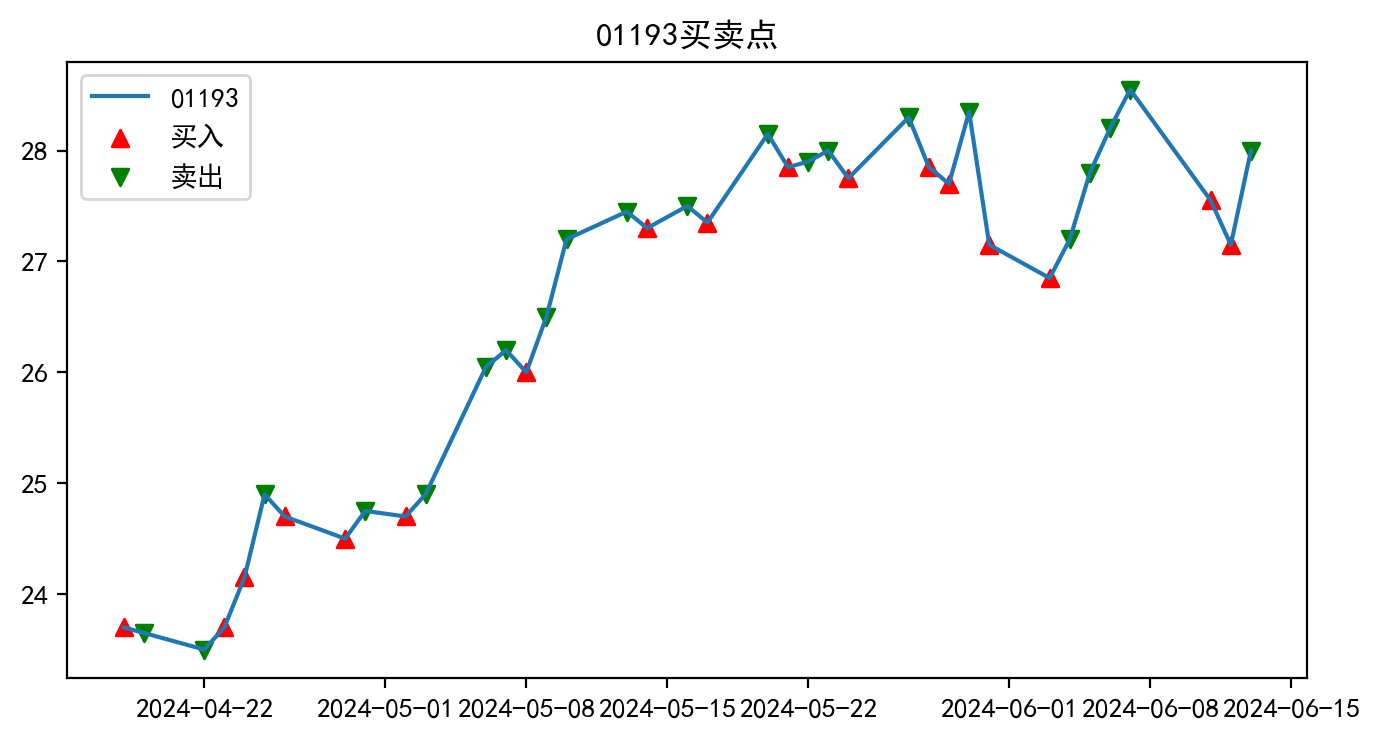

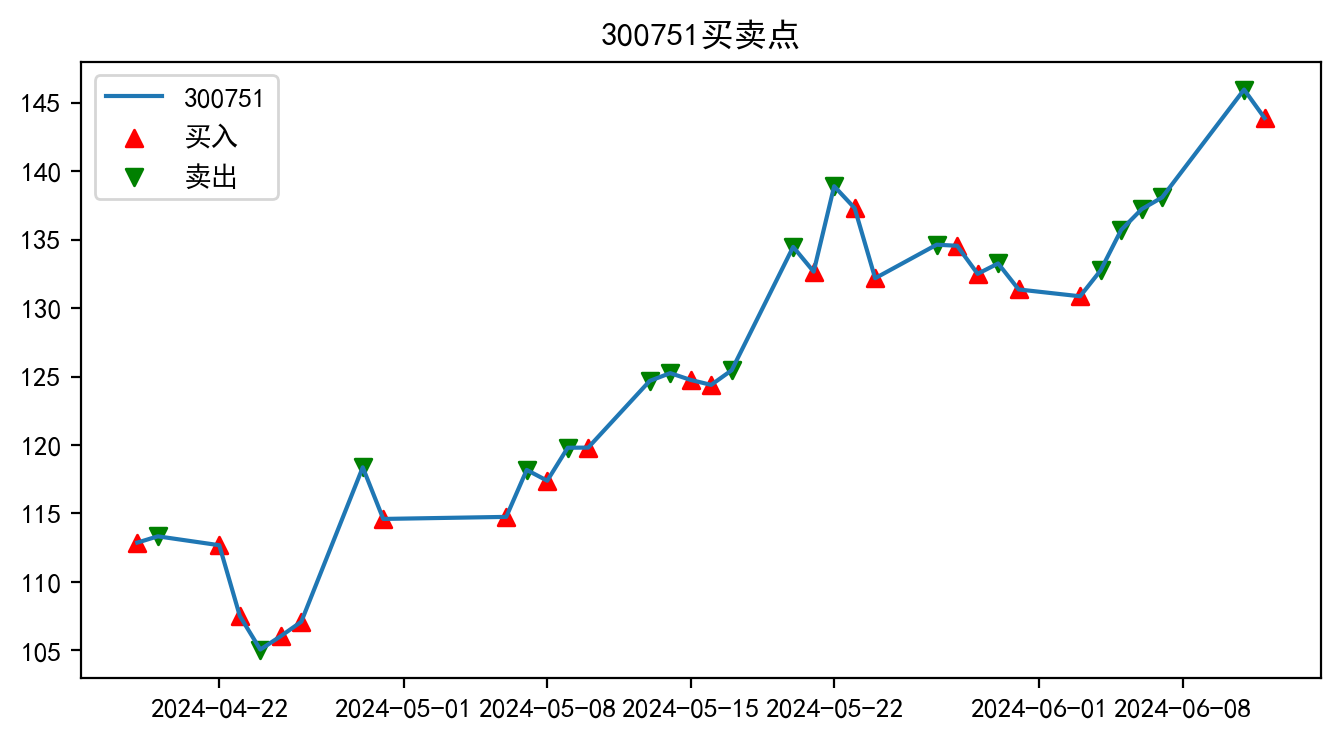

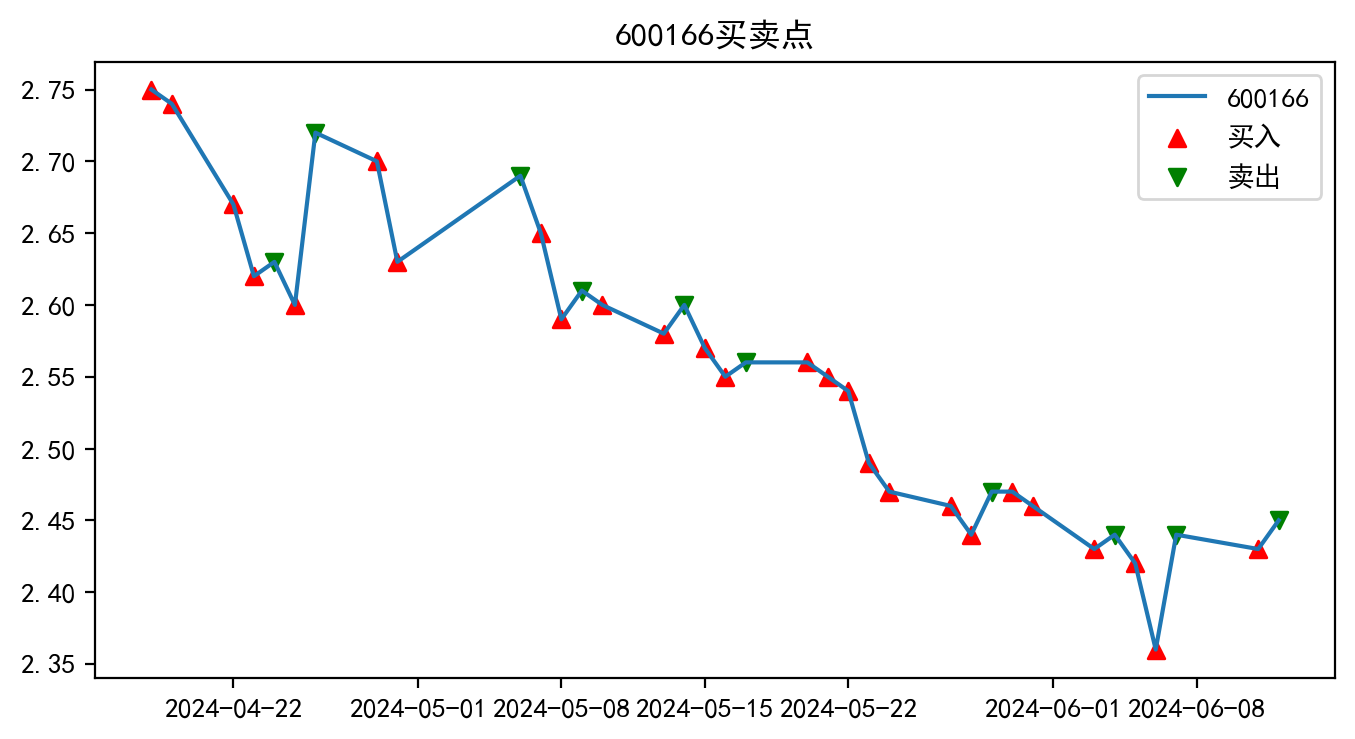

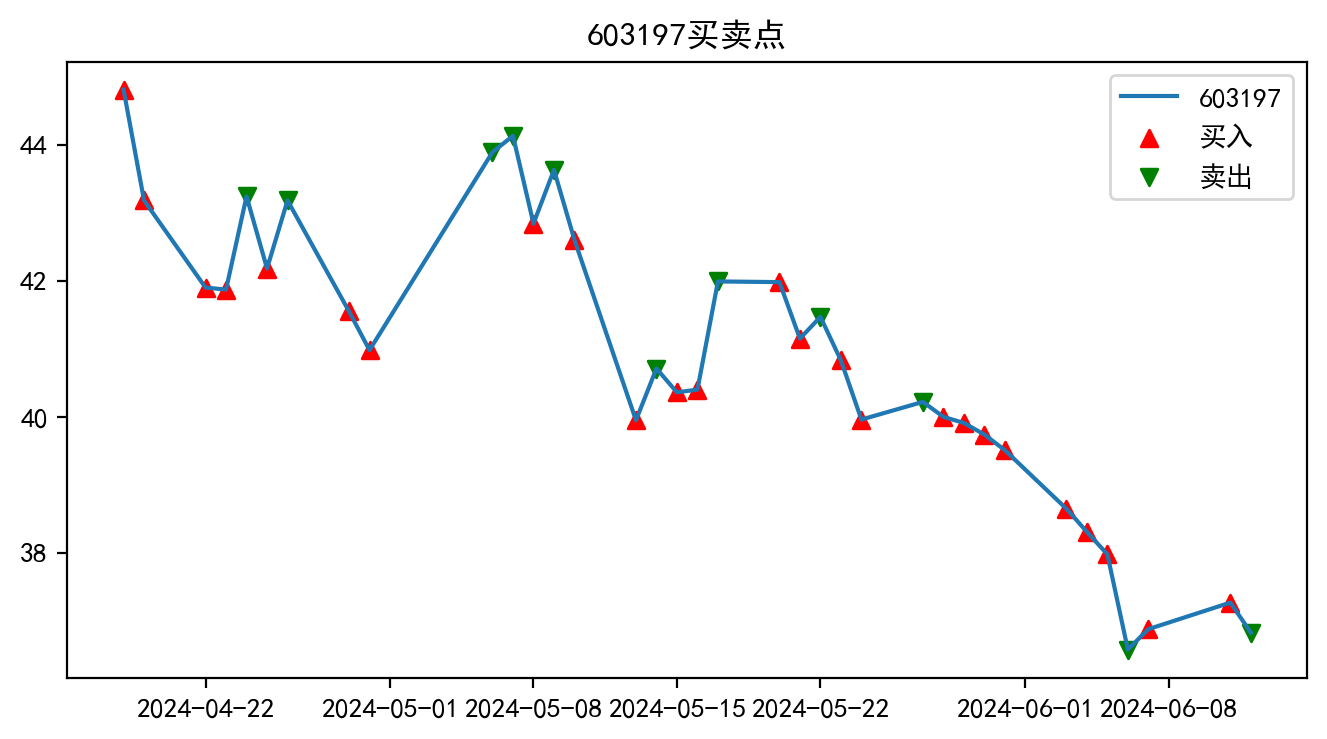

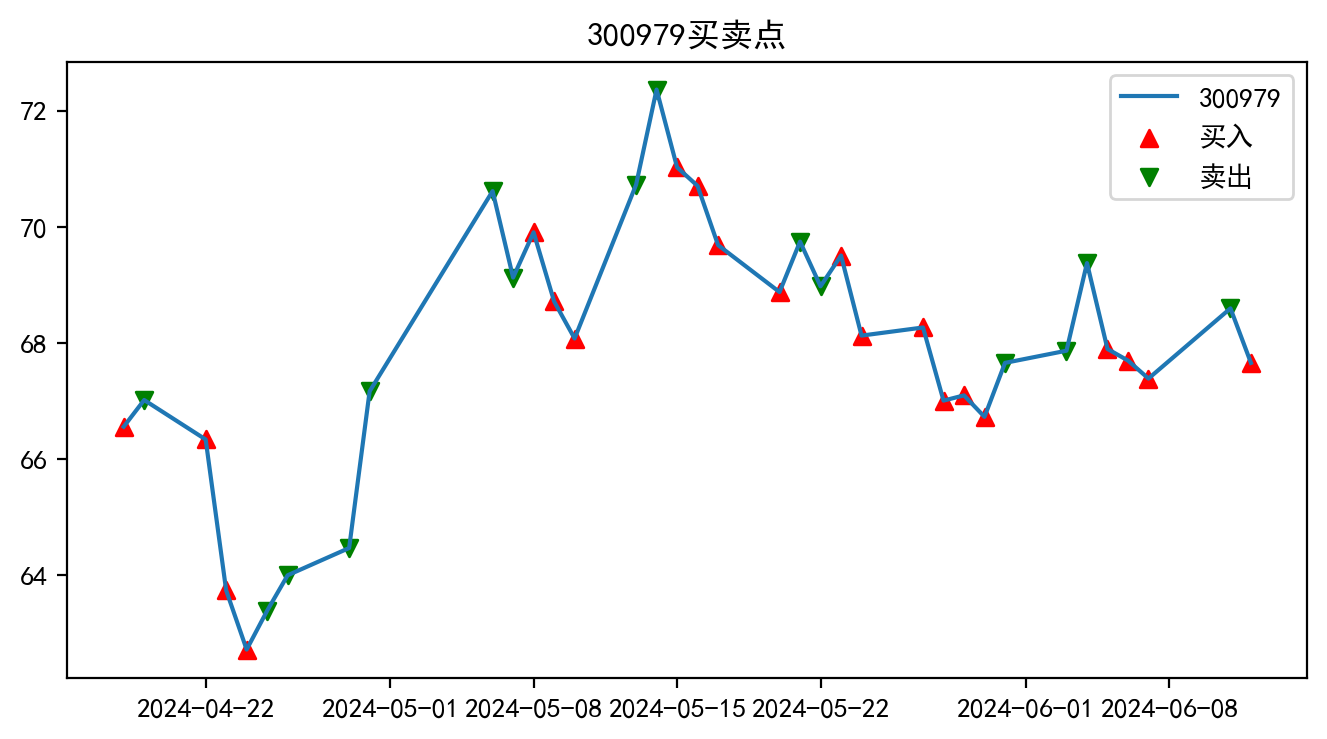

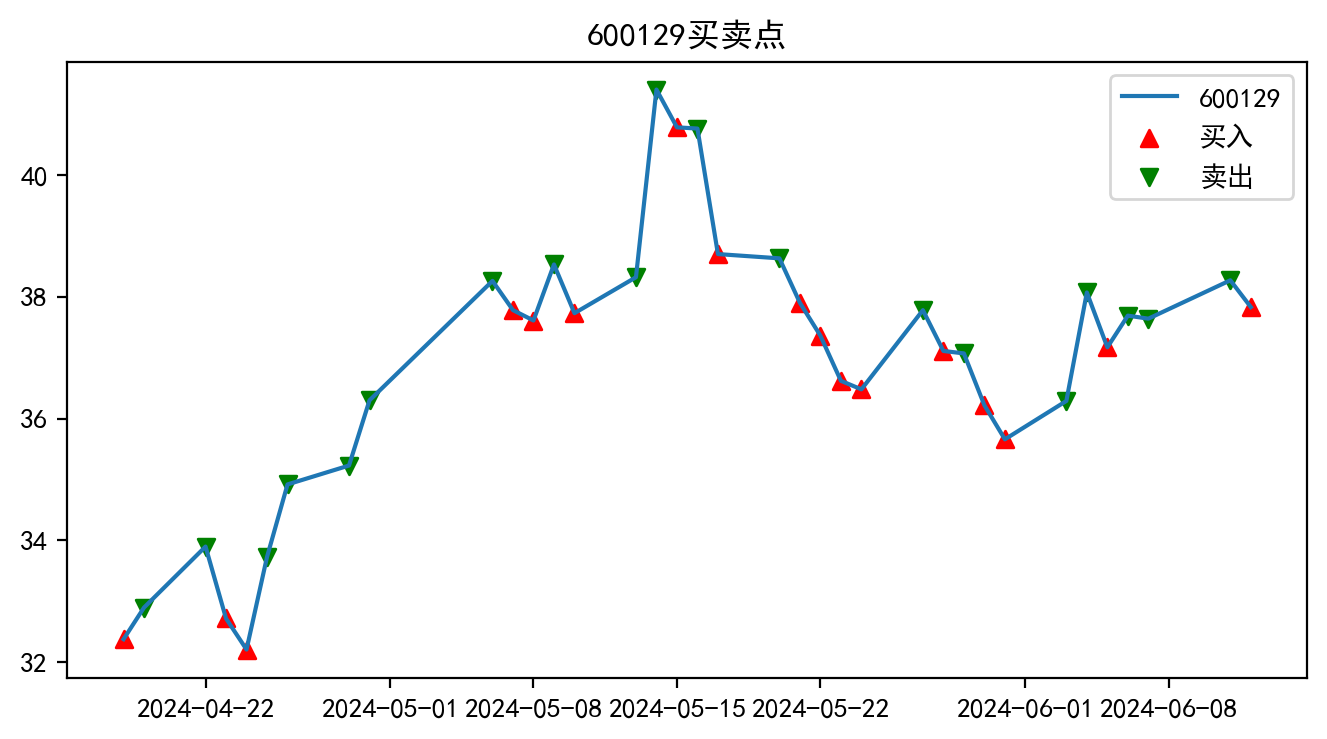

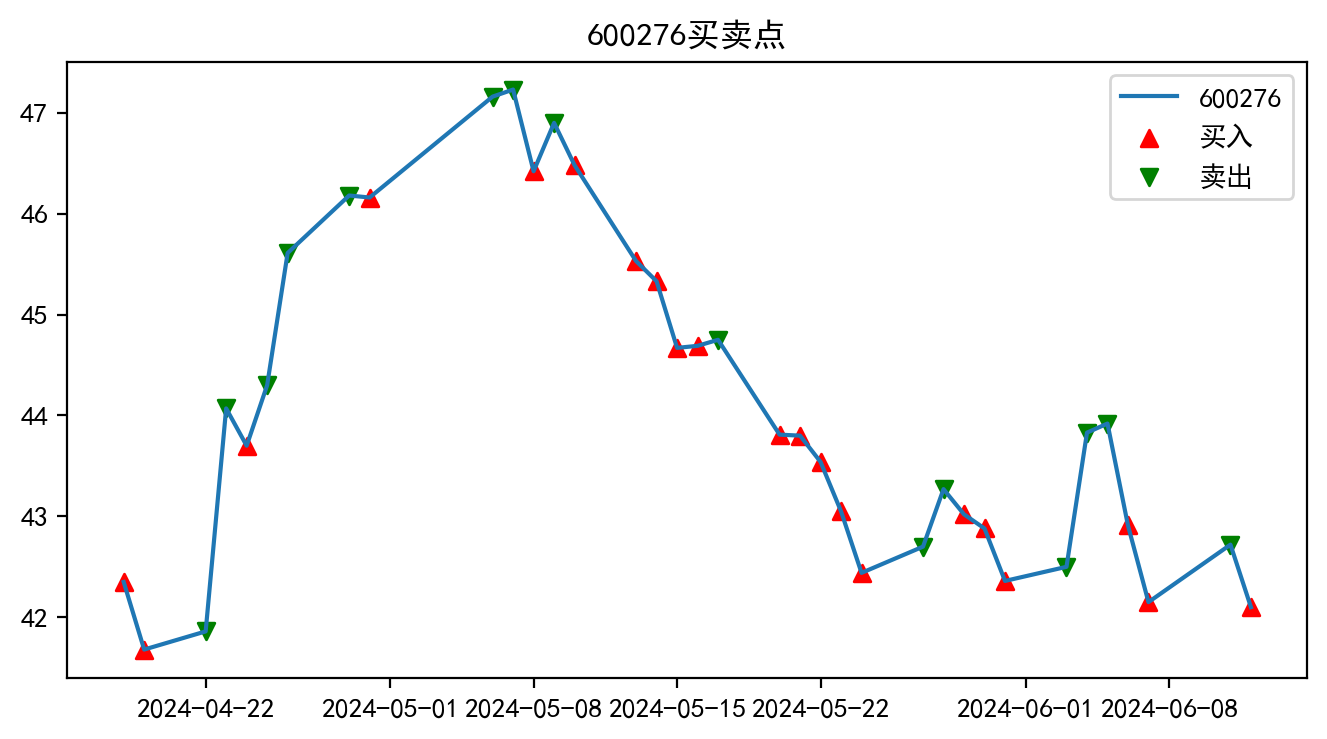

In [10]:
for stock in stock_list:
    price_df = price_df_A.loc[:, stock] if len(stock) == 6 else price_df_H.loc[:, stock]
    position_chg = snowball_positions[stock].diff(1)
    position_chg.iloc[0] = snowball_positions[stock].iloc[0]
    # 红色为买入，绿色为卖出
    data = pd.concat([price_df.loc[bt_start_date:bt_end_date], position_chg], axis=1)
    data.columns = ["价格", "仓位变化"]
    plt.figure(figsize=(8, 4))
    plt.plot(data["价格"], label=stock)
    plt.scatter(
        data.loc[data["仓位变化"] > 0, "仓位变化"].index,
        data.loc[data["仓位变化"] > 0, "价格"],
        color="red",
        marker="^",
        label="买入",
    )
    plt.scatter(
        data.loc[data["仓位变化"] < 0, "仓位变化"].index,
        data.loc[data["仓位变化"] < 0, "价格"],
        color="green",
        marker="v",
        label="卖出",
    )
    plt.title(f"{stock}买卖点")
    plt.legend()